## C　線形回帰を用いた荻窪のワンルーム賃料の予測

### 荻窪のワンルーム賃料の予測タスク

#### データを読み込もう

In [1]:
# データの読み込み
import pandas as pd
filepath_train = "./data/ogikubo_oneroom_train.csv"
oneroom_train = pd.read_csv(filepath_or_buffer = filepath_train)
oneroom_train.head(n = 5)

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
1,メゾン・ド・荻窪,4.5,12.11,40,7,0,0
2,ＪＲ中央線 荻窪駅 3階建 築40年,4.5,12.11,40,6,0,0
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1
4,グローリア初穂阿佐ヶ谷,6.0,16.65,31,15,0,1


《スクリプトの説明》
* 1行目 : Pythonでデータフレーム周りをサポートしている`pandas`というパッケージをimportします。
* 2行目 : データをレコードしたcsvファイルがあるパスを`filepath_train`という名前で準備しました。
* 3行目 : パス`filepath_train`にあるcsvファイルを`read_csv`メソッドで読み込みます。
* 4行目 : 読み込んだファイルを確認するために頭5行を出してみました。

In [2]:
# データの次元
oneroom_train.shape

(100, 7)

In [3]:
oneroom_train.query('name == "フェリーチェ上井草A"')

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1


#### 荻窪の家賃予測タスクの説明
前節にPythonで読み込んだデータですが、これは荻窪のワンルームマンションの物件に関する情報を収集してきた実データです。次のような変数をレコードしてきました。
* name : 物件名
* value : 家賃[万円]
* area : 面積[m²]
* age : 築年数[年]（注 : 新築の場合0年）
* distance : 最寄り駅（JR中央線荻窪駅）まで徒歩でかかる時間[分]
* bath_toilet_separated : バス・トイレ別（1 : True, 0 : False）
* autolock : オートロック（1 : True, 0 : False ）

今回は「荻窪のワンルームマンションの家賃を他の物件情報を用いて予測できるようにしよう」というタスクに線形回帰モデルで挑戦してみたいと思います。

#### データの可視化

家賃を予測する上で必要そうな変数はなにかを絞るために、散布図に注目しましょう。

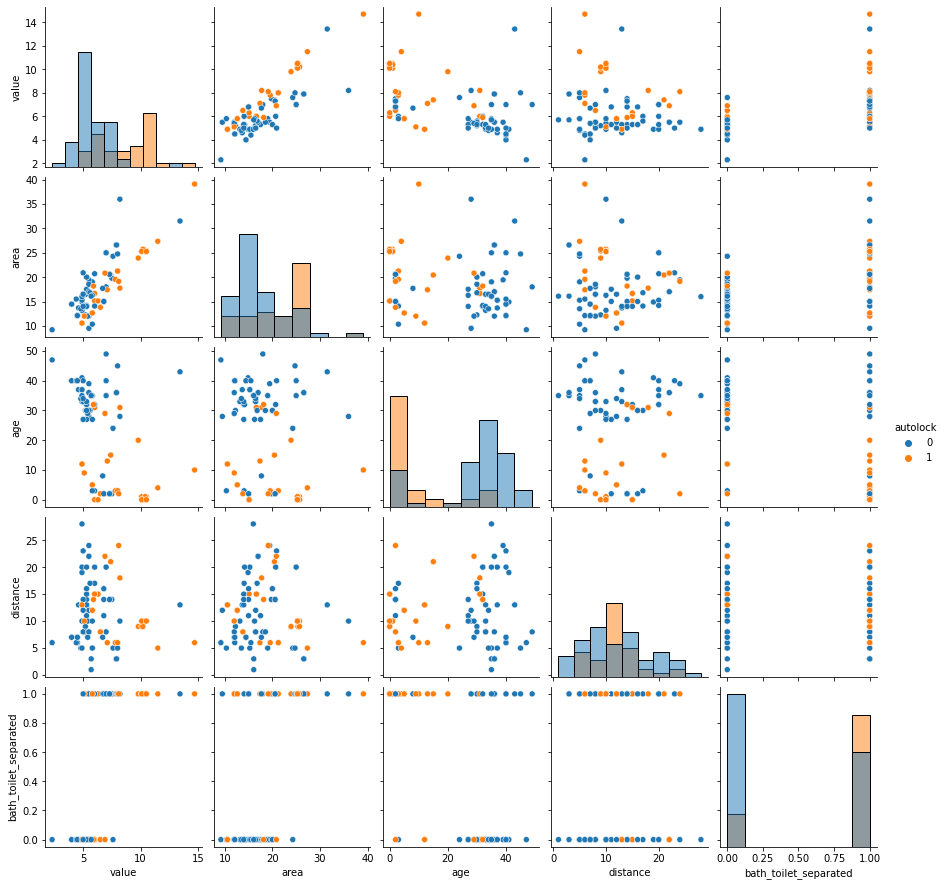

In [4]:
# データの可視化
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(oneroom_train, hue = "autolock", diag_kind = "hist")
plt.show()

《散布図の説明》

散布図は各データポイントの2つの変数の数値を、対応する2軸の座標上に点でプロットしたグラフのことをいいます。例えば、1行2列目のグラフは各データポイントの`area`と`value`の数値を、xy座標上にプロットしたものです。

《スクリプトの説明》
* 1行目 : Pythonで可視化周りをサポートしている`seaborn`というパッケージをimportします。
* 2行目 : Pythonで可視化周りをサポートしている`matplotlib.pyplot`というモジュールをimportします。
* 3行目 : `seaborn`の`pairplot`メソッドで各変数間の散布図を描きます。
    - `data`引数 : 散布図を書きたいデータ（`pandas.DataFrame`クラス）
    - `hue`引数 : 色分けする変数を指定できます。
* 4行目 : `pairplot`メソッドで作ったグラフを`show`メソッドで出力します。

《考察》

今回、`value`（家賃）を予測するうえで必要な変数を探すことが目標でした。実は、1行目のグラフが重要な情報を持っていることに気付くでしょうか。例えば、`area`と`value`の関係はどうでしょう。`area`が大きくなると`value`も大きい値になることが見て取れ、予測に必要そうな変数であることが分かりますね。一方で`distance`はどうでしょうか。`distance`が変化してもあまり`value`は変化せず、あまり予測には必要な変数ではなさそうに見て取れます。

「`value`を予測するための変数として、`area`は選択し`distance`は選択しない。」と判断しました。まさにこのプロセスが特徴量選択です。そして特徴量選択には散布図によるデータの可視化が大いに役に立ちます。

**演習** 他の変数`age`, `bath_toilet_separated`, `autolock`についても、`value`を予測するうえで必要そうな変数かを考察してみてください。（これが正解というものはないので気楽に考えてみましょう。）

《スクリプトの説明》
* 1行目 : Pythonで可視化周りをサポートしている`seaborn`というパッケージをimportします。
* 2行目 : Pythonで可視化周りをサポートしている`matplotlib.pyplot`というモジュールをimportします。
* 3行目 : `seaborn`パッケージのdistplot`メソッドでヒストグラムを描画します。
    - `a`引数 : ヒストグラムを描きたいデータ（`numpy.1darray`クラス）
    - `bins`引数 : binの個数を指定します。
* 4行目 : `pairplot`メソッドで作ったグラフを`show`メソッドで出力します。

#### 特徴量選択とLasso回帰モデルの学習

#### 特徴量選択

In [5]:
# 特徴量選択
feature_name = ["area", "age", "bath_toilet_separated"]
X_train = oneroom_train[feature_name].values
y_train = oneroom_train["value"].values

In [6]:
X_train.shape, y_train.shape

((100, 3), (100,))

《スクリプトの説明》
* 1行目 : 散布図を参考に選択した特徴量のリストを作ります。
* 2行目 : データから特徴量として選択した列のみを抽出し、`numpy.2darray`の形で取得します。
* 3行目 : データから予測したい変数`value`を抽出し、`numpy.1darray`の形で取得します。

#### 入力変数の正規化
以下ではLasso回帰を行っていくので、入力変数を正規化しておきましょう。

In [7]:
# 入力変数の正規化（標準化）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### ハイパーパラメータの探索
Lasso正則化ハイパーパラメータ$\apha$を探索しておきましょう。

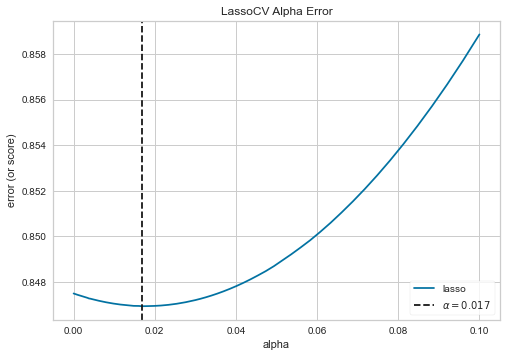

In [8]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
import numpy as np
alphas = np.logspace(-10, -1, 500)    # alphaの探索空間 = [10**(-10), 10**(-1)]
model_cv = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model_cv)
visualizer.fit(X_train, y_train)
visualizer.show()
plt.show()

#### Lasso回帰モデルの学習

In [9]:
# Lasso回帰モデルで回帰モデルを作る。
from sklearn.linear_model import Lasso
model = Lasso(alpha = 0.017)
model.fit(X_train, y_train)

Lasso(alpha=0.017)

In [10]:
model.intercept_,model.coef_

(6.940299999999999, array([ 1.5948933 , -0.72409219,  0.21732711]))

#### モデルの評価
さて、あと一息です。予測モデルを作成したら、そのモデルの良さを評価しましょう。モデルの良さには2つの軸
* 学習に用いたデータをどれくらい学習できたか。
* 未知のデータに対してどれだけ精度よく予測できるか。

があることを見ていきます。

#### 学習に用いたデータにおけるモデルの評価
予測モデルを評価するときに役に立つものとして、**決定係数**と**残差プロット**があります。決定係数は数値的な評価指標で、予測と実際の値がばっちり一致していたら1.0となり、食い違うほどどんどん低い値になります。また、負の数になることもあります。残差プロットは予測値を横軸、残差（= 実測値と予測値の差）を縦軸にしてプロットしたグラフのことで、残差の規模感を実際の予測変数の規模感と比較して「精度」を評価するのに役立ちます。ここでは決定係数の計算を行い、残差プロットは後程紹介します。

In [11]:
# 決定係数によるモデルの評価
from sklearn.metrics import r2_score
pred_train = model.predict(X_train)
r2_score(y_true = y_train, y_pred = pred_train)

0.8611372995397126

《スクリプトの説明》
* 1行目 : `sklearn`パッケージの`metrics`モジュールから`r2_score`メソッドをimportします。
* 2行目 : 学習に用いた特徴量のデータから`value`変数の予測値を計算します。
* 3行目 : `r2_score`メソッドで決定係数を計算します。
    - `y_true`引数 : 実際の値
    - `y_pred`引数 : 予測モデルから計算できる予測値

《考察》

決定係数が1.0に近いことから、データを良く学習できていることが見て取れます。また、残差プロットからも、残差が±2万円程度に収まっていることが見て取れます。また、予測値が大きい部分に残差の大きなデータポイントがみられるので、外れ値かどうかの確認が必要そうです。

#### 未知のデータにおけるモデルの評価
予測モデルは、実はその学習の仕組みから、学習したデータに対する予測精度は可能な限り高くなるようになっていることが分かります。ここで注意を払いたいのは、本来「予測の精度」とは新しく入ってきたデータに対しても、上手く予測できることを指すという点です。要するに、学習したデータを用いたモデルの評価は、学習が上手く進んでいたかを確認する指標にはなっても、予測の精度を評価する指標にはなりません。そこで、機械学習では、事前に学習に使わないデータを別に作っておいて、精度評価のためだけに用いるということを行います。

In [12]:
# 未知データの読み込み
import pandas as pd
filepath_test = "./data/ogikubo_oneroom_test.csv"
oneroom_test = pd.read_csv(filepath_or_buffer = filepath_test)
oneroom_test.shape

(61, 7)

In [13]:
oneroom_test.head(n = 5)

,name,value,area,age,distance,bath_toilet_separated,autolock
0,ＪＲ中央線 西荻窪駅 6階建 築32年,5.9,18.17,32,14,0,1
1,スパシエグランス荻窪 1002号室,8.9,25.46,2,14,1,1
2,ＪＲ中央線 西荻窪駅 2階建 築34年,6.5,18.00,34,13,1,0
3,ＪＲ中央線 阿佐ヶ谷駅 2階建 築2年,7.3,20.58,2,11,1,0
4,第二コーポ石原 206号室,6.0,16.00,26,15,0,1


In [14]:
# 未知データの入力と出力を作る。
X_test = oneroom_test[feature_name].values
X_test = scaler.transform(X_test)    # 入力の標準化を忘れずに。
y_test = oneroom_test["value"].values

In [15]:
# 未知データに対する決定係数
from sklearn.metrics import r2_score
pred_test = model.predict(X_test)
r2_score(y_test, pred_test)

0.8889970270966485

#### 残差プロット

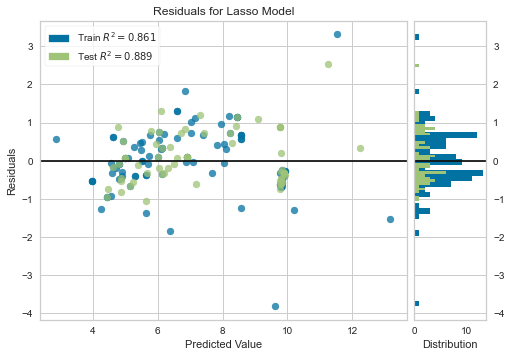

In [16]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model, is_fitted = True)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

《考察》

未知のデータに対しても決定係数は1.0に近い値をとっていることから、予測モデルの精度は高いことが見て取れます。特に残差プロットからも、残差はおよそ±1万円程度に収まっていることがわかります。